<a href="https://colab.research.google.com/github/ChaseAdamson/Housing-Prices/blob/main/Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyze and Predict Housing Prices

The following notebook explores the housing data in the california housing data set and trains a linear regression model, a random forest model, and a quantile regression forest model to predict the median housing values of neighborhoods in the data set using the features of the neighborhoods. A confidence interval is also created using the quantile regression forest model.


# Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split # Used for splitting data
from sklearn.linear_model import LinearRegression # Used for training model 1
from sklearn.ensemble import RandomForestRegressor # Used for training model 2
!pip install lightgbm
import lightgbm as lgb # used for training model 3
from sklearn.metrics import mean_squared_error, r2_score # Used for testing models
import numpy as np
import matplotlib.pyplot as plt # Used for visualizing data

# Import California Housing Data

In [2]:
from sklearn.datasets import fetch_california_housing

# Load dataset
data = fetch_california_housing(as_frame=True)

# Convert to pandas DataFrame
df = data.frame

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Split Data Into Testing and Training Data

In [3]:
# Separate features (X) and target variable (y)
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% for testing, leaves 80% for training
    random_state=42      # seed ensures reproducible random split
)

X_train.shape, X_test.shape

((16512, 8), (4128, 8))

# Create and train models
The models are created and fitted with the data. The confidence interval is created by training two other lgb models to predict to the bottom 10th percentile and 90th percentile. The interval between these values contains the

In [4]:
# Create and train(fit) the linear regression model
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

# Create and train the random forest model
model_forest = RandomForestRegressor()
model_forest.fit(X_train, y_train)

# Create and train quantile forest regression model for confidence intervals
model_lgb = lgb.LGBMRegressor(
    objective="quantile",
    alpha=0.5,
    n_estimators=500
)
model_lgb.fit(X_train, y_train)

model_lgb_lower = lgb.LGBMRegressor(
    objective="quantile",
    alpha=0.1,
    n_estimators=500
)
model_lgb_lower.fit(X_train, y_train)

model_lgb_upper = lgb.LGBMRegressor(
    objective="quantile",
    alpha=0.9,
    n_estimators=500
)
model_lgb_upper.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 1.798500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 0.825000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start traini

LGBMRegressor(alpha=0.9, n_estimators=500, objective='quantile')

# Test Linear Regression Model

In [5]:
# Make predictions with the linear regression model
y_pred_linear = model_linear.predict(X_test)

# Make predictions with the random forest model
y_pred_forest = model_forest.predict(X_test)

# Make predictions with the QRF model
y_pred_lgb = model_lgb.predict(X_test)

# Make confidence interval
y_pred_lgb_lower = model_lgb_lower.predict(X_test)
y_pred_lgb_upper = model_lgb_upper.predict(X_test)

# Test predictions against real data using RMSE and R^2
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)
print(f'linear rmse = {rmse_linear}, linear R^2 = {r2_linear}')

# Test predictions against real data using RMSE and R^2
rmse_forest = np.sqrt(mean_squared_error(y_test, y_pred_forest))
r2_forest = r2_score(y_test, y_pred_forest)
print(f'forest rmse = {rmse_forest}, forest R^2 = {r2_forest}')

# Test predictions against real data using RMSE and R^2
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f'lgb rmse = {rmse_lgb}, lgb R^2 = {r2_lgb}')

calibration_rate = ((np.array(y_test) >= np.array(y_pred_lgb_lower)) & (np.array(y_test) <= y_pred_lgb_upper)).mean()
print(f'calibration rate = {calibration_rate}')

# Predicting prices for 5 random medhousevals to 80% confidence
indices = np.random.choice(len(y_test), size=5, replace=False)
print("80% confident median house values:")
for i in indices:
    mid = y_pred_lgb[i]
    low = y_pred_lgb_lower[i]
    high = y_pred_lgb_upper[i]
    delta = (high - low) / 2

    print(f"Predicted median house value: ${mid*100000:.0f} ± ${delta*100000:.0f}")

linear rmse = 0.7455813830127764, linear R^2 = 0.5757877060324508
forest rmse = 0.5055013160819586, forest R^2 = 0.8049986036392858
lgb rmse = 0.4684965189875767, lgb R^2 = 0.83250344591036
calibration rate = 0.6913759689922481
80% confident median house values:
Predicted median house value: $183029 ± $33746
Predicted median house value: $321195 ± $58253
Predicted median house value: $163062 ± $17189
Predicted median house value: $177436 ± $42875
Predicted median house value: $344185 ± $68750


From these results, we can expect the model to deviate from the Median Home Value of an entry by about $75,000 because the units are scaled by a factor of 100,000.

We can also interpret the results to indicate the model accounts for about 58% of the median value of a given data entry of homes.

The following code block visualizes the predicted data and the real data with a scatter plot.

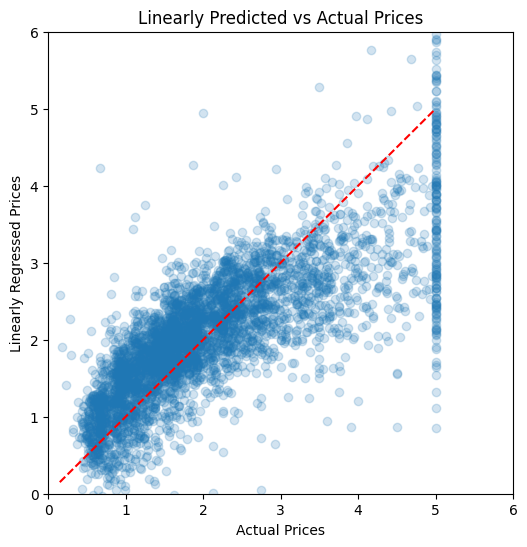

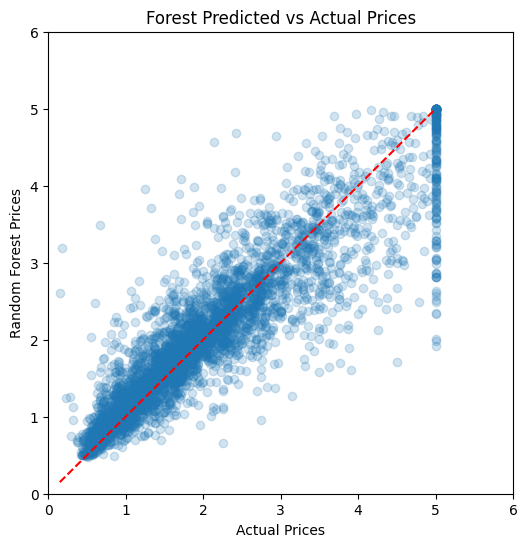

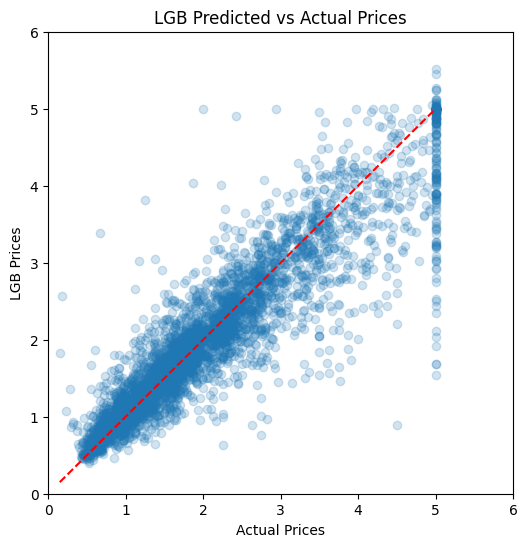

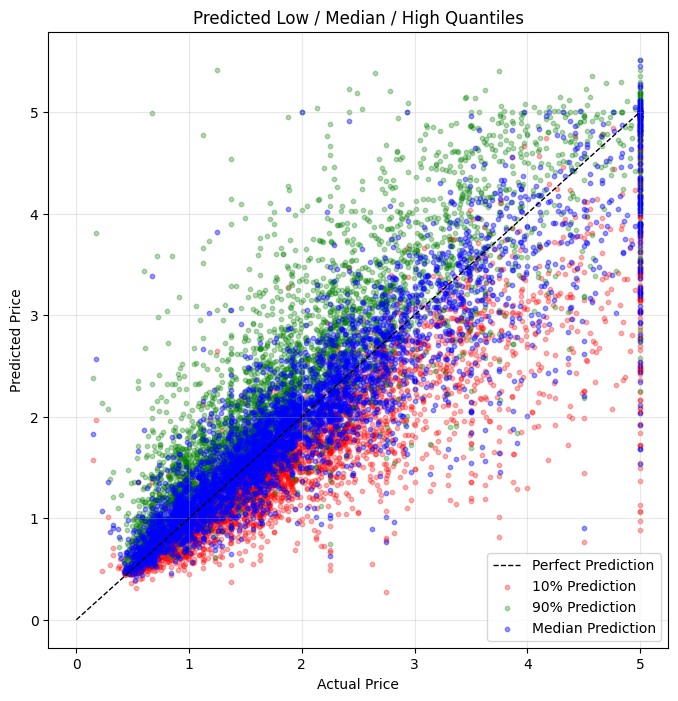

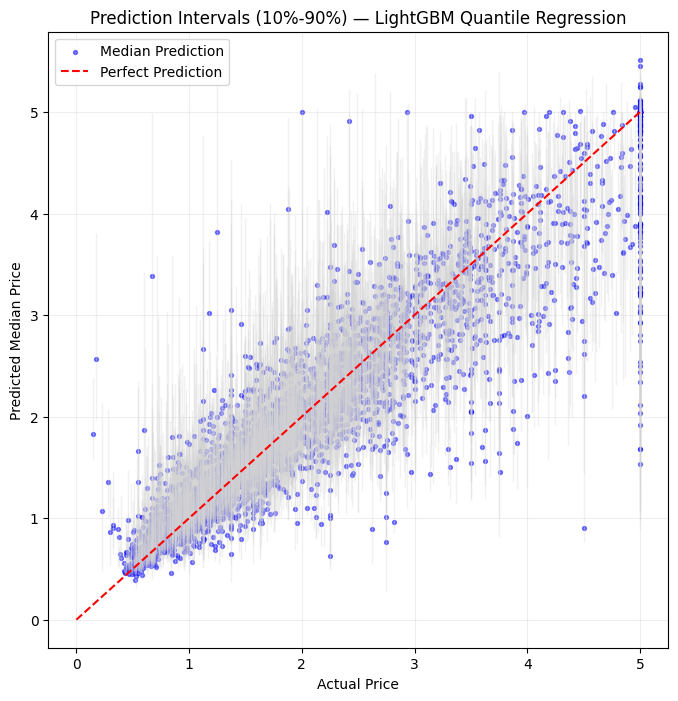

In [6]:
# Set reasonable limit values
min = 0
max = 6

# Plot linear regression prices
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_linear, alpha=0.2)
plt.xlim(min, max)
plt.ylim(min, max)
plt.xlabel("Actual Prices")
plt.ylabel("Linearly Regressed Prices")
plt.title("Linearly Predicted vs Actual Prices")
plt.xlim()
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')  # perfect predictions line
plt.show()

# Plot random forest prices
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_forest, alpha=0.2)
plt.xlim(min, max)
plt.ylim(min, max)
plt.xlabel("Actual Prices")
plt.ylabel("Random Forest Prices")
plt.title("Forest Predicted vs Actual Prices")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')  # perfect predictions line
plt.show()

# Plot lgb prices
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lgb, alpha=0.2)
plt.xlim(min, max)
plt.ylim(min, max)
plt.xlabel("Actual Prices")
plt.ylabel("LGB Prices")
plt.title("LGB Predicted vs Actual Prices")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')  # perfect predictions line
plt.show()

# plot low and high confidence interval predictions
actual = np.array(y_test)
plt.figure(figsize=(8, 8))
min_val = 0
max_val = 5
plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1, label="Perfect Prediction")

# Plot the low, median, and high predictions with different colors
plt.scatter(actual, y_pred_lgb_lower,  s=10, alpha=0.3, color="red",   label="10% Prediction")
plt.scatter(actual, y_pred_lgb_upper, s=10, alpha=0.3, color="green", label="90% Prediction")
plt.scatter(actual, y_pred_lgb,  s=10, alpha=0.4, color="blue",  label="Median Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted Low / Median / High Quantiles")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Create confidence interval scatter plot
# Sort by actual values so intervals display cleanly
order = np.argsort(y_test)
actual_sorted = np.array(y_test)[order]
low_sorted = np.array(y_pred_lgb_lower)[order]
med_sorted = np.array(y_pred_lgb)[order]
high_sorted = np.array(y_pred_lgb_upper)[order]

plt.figure(figsize=(8, 8))

# Light, thin interval bars
plt.vlines(
    actual_sorted,
    low_sorted,
    high_sorted,
    color="lightgray",
    alpha=0.3,
    linewidth=1
)

# Median predictions
plt.scatter(
    actual_sorted,
    med_sorted,
    s=8,
    alpha=0.5,
    color="blue",
    label="Median Prediction"
)

# Perfect prediction line
plt.plot([0, 5], [0, 5], "r--", label="Perfect Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Median Price")
plt.title("Prediction Intervals (10%-90%) — LightGBM Quantile Regression")
plt.legend()
plt.grid(alpha=0.2)
plt.show()


# Analysis

The model looks like it slightly over-predicted for homes cheaper than 150K and under-predicted for home more expensive than $250K. The vertical line at 500K is caused because there are lots of data entries for which the medhouseval is 500K, so the scatter plot forms a vertical line there. The line is long which indicates the model does a poor job at predicting the price of homes at 500K.

This model is most useful for homes between 150K and 250K